<a href="https://colab.research.google.com/github/Allessyer/Test_Problem/blob/main/task_1/Burnaev_lab_task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installation

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# cd /content/drive/MyDrive/Стажировки/Burnaev_lab

In [4]:
# !git clone https://github.com/cloneofsimo/minDiffusion

In [5]:
cd /content/drive/MyDrive/Стажировки/Burnaev_lab/minDiffusion

/content/drive/MyDrive/Стажировки/Burnaev_lab/minDiffusion


### Libraries

In [6]:
from typing import Dict, Tuple
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from torchvision.datasets import ImageFolder
import os


import matplotlib.pyplot as plt
import numpy as np

device="cuda:0"

In [7]:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io

from os import listdir
from os.path import isfile, join
import os
import cv2

In [8]:
!nvidia-smi

Sat Jul  9 00:57:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### My functions

In [9]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [10]:
def plot_image(image):
    unorm = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    image = unorm(image)
    image = image.numpy()
    image = np.rollaxis(image,0,3)
    plt.imshow(image)
    plt.show()

### Model

In [11]:
from mindiffusion.unet import NaiveUnet
from mindiffusion.ddpm import DDPM

In [12]:
ddpm = DDPM(eps_model=NaiveUnet(3, 3, n_feat=128), betas=(1e-4, 0.02), n_T=1000)
ddpm.to(device)

DDPM(
  (eps_model): NaiveUnet(
    (init_conv): Conv3(
      (main): Sequential(
        (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(8, 128, eps=1e-05, affine=True)
        (2): ReLU()
      )
      (conv): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(8, 128, eps=1e-05, affine=True)
        (2): ReLU()
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): GroupNorm(8, 128, eps=1e-05, affine=True)
        (5): ReLU()
      )
    )
    (down1): UnetDown(
      (model): Sequential(
        (0): Conv3(
          (main): Sequential(
            (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): GroupNorm(8, 128, eps=1e-05, affine=True)
            (2): ReLU()
          )
          (conv): Sequential(
            (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         

### Dataset

#### CIFAR10

In [ ]:
tf = transforms.Compose(
        [
            transforms.ToTensor(), 
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
    )

dataset = CIFAR10(
    "./data",
    train=True,
    download=True,
    transform=tf,
)

dataloader = DataLoader(dataset, batch_size=512, shuffle=True, num_workers=16)
optim = torch.optim.Adam(ddpm.parameters(), lr=1e-5)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


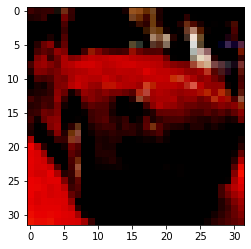

In [ ]:
image, label = dataset[5]
plot_image(image)

#### FoodNet Dataset

##### Create annotations file

In [ ]:
def create_annotations_file(path2Datasetdir, mode):
    df = pd.DataFrame()

    path2folder = f'{path2Datasetdir}/{mode}/{mode}-org-img'
    onlyfiles = [f for f in listdir(path2folder) if isfile(join(path2folder, f))]
    df['image'] = onlyfiles
    df['label'] = np.full(df.shape[0], 0)
    df['mode'] = np.full(df.shape[0], mode)

    return df

In [ ]:
path2Datasetdir = "/content/drive/MyDrive/Стажировки/Burnaev_lab/FloodNet_Dataset/FloodNet-Supervised_v1.0"

In [ ]:
df_train = create_annotations_file(path2Datasetdir, mode='train')
df_valid = create_annotations_file(path2Datasetdir, mode='val')
df_test = create_annotations_file(path2Datasetdir, mode='test')
df = pd.concat([df_train, df_valid, df_test])

In [ ]:
path2save = '/content/drive/MyDrive/Стажировки/Burnaev_lab/FloodNet_Dataset'
df.to_csv(f'{path2save}/annotations_file.csv',index=False)

##### Create FloodNet Dataset

In [ ]:
class FloodNetDataset(Dataset):
    def __init__(self, annotations_file, dataset_dir, mode, transform=None):
        self.mode = mode
        self.dataset_dir = dataset_dir
        df = pd.read_csv(annotations_file)
        self.annotations = df[df['mode'] == self.mode]  
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label = self._get_sample_label(index)
        sample_path = self._get_sample_path(index)
        image = io.imread(sample_path)

        if self.transform:
            image = self.transform(image)

        return (image, label)

    def _get_sample_path(self, index):
        path = os.path.join(self.dataset_dir, self.mode, f'{self.mode}-org-img', 
                            self.annotations.iloc[index, 0])
        return path

    def _get_sample_label(self, index):
        return torch.tensor(self.annotations.iloc[index, 1])


In [ ]:
ANNOTATIONS_FILE = "/content/drive/MyDrive/Стажировки/Burnaev_lab/FloodNet_Dataset/annotations_file.csv"
DATASET_DIR = '/content/drive/MyDrive/Стажировки/Burnaev_lab/FloodNet_Dataset/FloodNet-Supervised_v1.0'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  

In [ ]:
transform = transforms.Compose([
                      transforms.ToPILImage(),
                      transforms.Resize((64, 64)),
                      transforms.ToTensor(), 
                      transforms.Normalize(
                          mean=(0.5, 0.5, 0.5), 
                          std=(0.5, 0.5, 0.5))
                  ])

In [ ]:
train_dataset = FloodNetDataset(ANNOTATIONS_FILE, DATASET_DIR, mode='train', transform=transform)
# print(f"There are {len(train_dataset)} samples in the dataset.")
# val_dataset = FloodNetDataset(ANNOTATIONS_FILE, DATASET_DIR, mode='val', transform=transform)
# print(f"There are {len(val_dataset)} samples in the dataset.")
# test_dataset = FloodNetDataset(ANNOTATIONS_FILE, DATASET_DIR, mode='test', transform=transform)
# print(f"There are {len(test_dataset)} samples in the dataset.")

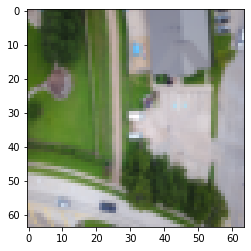

In [ ]:
image, label = train_dataset[5]
plot_image(image)

In [ ]:
dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=2)
optim = torch.optim.Adam(ddpm.parameters(), lr=1e-4)

### Train

#### CIFAR10

In [ ]:
n_epoch = 100

In [ ]:
for i in range(n_epoch):
      print(f"Epoch {i} : ")
      ddpm.train()

      pbar = tqdm(dataloader)
      loss_ema = None
      for x, _ in pbar:
          optim.zero_grad()
          x = x.to(device)
          loss = ddpm(x)
          loss.backward()
          if loss_ema is None:
              loss_ema = loss.item()
          else:
              loss_ema = 0.9 * loss_ema + 0.1 * loss.item()
          pbar.set_description(f"loss: {loss_ema:.4f}")
          optim.step()

      ddpm.eval()
      with torch.no_grad():
          xh = ddpm.sample(8, (3, 32, 32), device)
          xset = torch.cat([xh, x[:8]], dim=0)
          grid = make_grid(xset, normalize=True, value_range=(-1, 1), nrow=4)
          save_image(grid, f"./contents/cifar_samples/ddpm_sample_cifar{i}.png")

          # save model
          torch.save(ddpm.state_dict(), f"./ddpm_cifar.pth")

Epoch 0 : 


  0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
loss: 0.9409:  45%|████▍     | 44/98 [01:02<01:13,  1.36s/it]

#### FlooNet Dataset

In [ ]:
n_epoch = 100
for i in range(n_epoch):
    print(f"Epoch {i} : ")
    ddpm.train()

    pbar = tqdm(dataloader)
    loss_ema = None
    number = 0
    
    for x, _ in pbar:
        optim.zero_grad()
        x = x.to(device)
        if number == 0:
            x_orig = x
            number += 1
        loss = ddpm(x)
        loss.backward()
        if loss_ema is None:
            loss_ema = loss.item()
        else:
            loss_ema = 0.9 * loss_ema + 0.1 * loss.item()
        pbar.set_description(f"loss: {loss_ema:.4f}")
        optim.step()

    ddpm.eval()
    with torch.no_grad():

        xh = ddpm.sample(8, (3, 64, 64), device)

        xset = torch.cat([xh, x_orig[:8]], dim=0)
        grid = make_grid(xset, normalize=True, value_range=(-1, 1), nrow=4)
        save_image(grid, f"./contents/floodnet_samples/ddpm_sample_floodnet_short{i}.png")

        # save model
        torch.save(ddpm.state_dict(), f"./ddpm_floodnet_short.pth")

Epoch 0 : 


loss: 0.2390: 100%|██████████| 46/46 [06:47<00:00,  8.86s/it]


Epoch 1 : 


loss: 0.1049: 100%|██████████| 46/46 [06:19<00:00,  8.24s/it]


Epoch 2 : 


loss: 0.0736: 100%|██████████| 46/46 [06:15<00:00,  8.16s/it]


Epoch 3 : 


loss: 0.0642: 100%|██████████| 46/46 [06:15<00:00,  8.16s/it]


Epoch 4 : 


loss: 0.0567: 100%|██████████| 46/46 [06:10<00:00,  8.06s/it]


Epoch 5 : 


loss: 0.0509: 100%|██████████| 46/46 [06:13<00:00,  8.12s/it]


Epoch 6 : 


loss: 0.0517: 100%|██████████| 46/46 [06:11<00:00,  8.08s/it]


Epoch 7 : 


loss: 0.0438: 100%|██████████| 46/46 [06:10<00:00,  8.06s/it]


Epoch 8 : 


loss: 0.0468: 100%|██████████| 46/46 [06:14<00:00,  8.13s/it]


Epoch 9 : 


loss: 0.0444: 100%|██████████| 46/46 [06:09<00:00,  8.04s/it]


Epoch 10 : 


loss: 0.0492: 100%|██████████| 46/46 [06:13<00:00,  8.11s/it]


Epoch 11 : 


loss: 0.0409: 100%|██████████| 46/46 [06:14<00:00,  8.15s/it]


Epoch 12 : 


loss: 0.0412: 100%|██████████| 46/46 [06:12<00:00,  8.11s/it]


Epoch 13 : 


loss: 0.0444: 100%|██████████| 46/46 [06:11<00:00,  8.08s/it]


Epoch 14 : 


loss: 0.0322: 100%|██████████| 46/46 [06:10<00:00,  8.05s/it]


Epoch 15 : 


loss: 0.0369: 100%|██████████| 46/46 [06:06<00:00,  7.96s/it]


Epoch 16 : 


loss: 0.0343: 100%|██████████| 46/46 [06:10<00:00,  8.04s/it]


Epoch 17 : 


loss: 0.0467: 100%|██████████| 46/46 [06:07<00:00,  7.98s/it]


Epoch 18 : 


loss: 0.0345: 100%|██████████| 46/46 [06:09<00:00,  8.04s/it]


Epoch 19 : 


loss: 0.0373: 100%|██████████| 46/46 [06:10<00:00,  8.06s/it]


Epoch 20 : 


loss: 0.0420: 100%|██████████| 46/46 [06:08<00:00,  8.00s/it]


Epoch 21 : 


loss: 0.0373: 100%|██████████| 46/46 [06:08<00:00,  8.02s/it]


Epoch 22 : 


loss: 0.0327: 100%|██████████| 46/46 [06:07<00:00,  7.99s/it]


Epoch 23 : 


loss: 0.0398: 100%|██████████| 46/46 [06:10<00:00,  8.05s/it]


Epoch 24 : 


loss: 0.0309: 100%|██████████| 46/46 [06:11<00:00,  8.07s/it]


Epoch 25 : 


loss: 0.0310: 100%|██████████| 46/46 [06:10<00:00,  8.06s/it]


Epoch 26 : 


loss: 0.0313:  43%|████▎     | 20/46 [02:40<02:58,  6.88s/it]